In [1]:
import numpy
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
class PINN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(PINN, self).__init__()
        activation = nn.Sigmoid  # Using Tanh as activation function for input and hidden layers
        self.input_layer = nn.Linear(input_size, hidden_size)

        # Hidden layers using ReLU activation function
        self.hidden_layers = nn.ModuleList(
            [nn.Sequential(nn.Linear(hidden_size, hidden_size),activation()) for _ in range(num_layers)]
        )

        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Apply input layer transformation
        output = torch.tanh(self.input_layer(x))

        # Apply each hidden layer transformation
        for layer in self.hidden_layers:
            output = layer(output)

        # Output layer
        f = self.output_layer(output)

        # Compute the first and second derivatives using autograd
        f_prime = torch.autograd.grad(f, x, torch.ones_like(f), create_graph=True)[0]
        f_double_prime = torch.autograd.grad(f_prime, x, torch.ones_like(f), create_graph=True)[0]

        return f, f_prime, f_double_prime

In [3]:
## Defining the PDE
def equation_1(f, x, m):
    f_x = torch.autograd.grad(f, x, torch.ones_like(f), create_graph=True)[0]
    f_xx = torch.autograd.grad(f_x, x, torch.ones_like(f), create_graph=True)[0]
    return (1 - x) * f_xx - f_x - f * m


In [4]:
x_train1 = torch.linspace(0, 1, 201).view(-1, 1).to(device).requires_grad_(True)

In [5]:
def boundary_conditions_loss1(f, f_prime):
    # Boundary condition at x=0: f(0) = 1
    loss_bc_0 = (f[0] - 1) ** 2
    # Boundary condition at x=1: f'(1) = 0
    loss_bc_1 = (f_prime[1]) ** 2
    return loss_bc_0 + loss_bc_1

In [30]:
# Loop for different m values
m_values = [0.01,0.1,1,10,100]
results = {}

for m in m_values:
    print(f"Training for m = {m}")

    # Reset the model parameters for each m
    torch.manual_seed(69)
    pinn = PINN(1, 35, 1, 10).to(device)
    optimizer = torch.optim.Adam(pinn.parameters(), lr=0.0005)

    # Training Loop
    epochs = 50001
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Compute loss
        f, f_prime, f_double_prime = pinn(x_train1)
        pde_loss = equation_1(f, x_train1, m).pow(2).mean()
        boundary_condition_loss = boundary_conditions_loss1(f, f_prime)

        p1 = 100
        total_loss = 1 * pde_loss + p1 * boundary_condition_loss

        if total_loss <= 0.009:
            print(f"Epoch {epoch}/{epochs}, Total Loss: {total_loss.item()}, pde Loss: {pde_loss.item()}, Boundary Loss: {boundary_condition_loss.item()}")
            break

        
        total_loss.backward(retain_graph=True)
        optimizer.step()

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}/{epochs}, Total Loss: {total_loss.item()}, pde Loss: {pde_loss.item()}, Boundary Loss: {boundary_condition_loss.item()}")

    # Evaluate the model after training
    f, _, _ = pinn(x_train1)

    # Store the results for plotting
    results[m] = f.cpu().detach().numpy()

Training for m = 0.01
Epoch 0/50001, Total Loss: 45.93825149536133, pde Loss: 1.0382719665358309e-05, Boundary Loss: 0.45938238501548767
Epoch 52/50001, Total Loss: 0.00366254523396492, pde Loss: 9.880967991193756e-05, Boundary Loss: 3.563735663192347e-05
Training for m = 0.1
Epoch 0/50001, Total Loss: 45.93927764892578, pde Loss: 0.0010382730979472399, Boundary Loss: 0.45938238501548767
Epoch 1000/50001, Total Loss: 0.009998992085456848, pde Loss: 0.009997991845011711, Boundary Loss: 1.0003320838336549e-08
Epoch 2000/50001, Total Loss: 0.009998961351811886, pde Loss: 0.009997962042689323, Boundary Loss: 9.991434346545702e-09
Epoch 3000/50001, Total Loss: 0.00999717228114605, pde Loss: 0.00999616738408804, Boundary Loss: 1.0048106346971508e-08
Epoch 4000/50001, Total Loss: 0.009841623716056347, pde Loss: 0.009756174869835377, Boundary Loss: 8.544897127649165e-07
Epoch 5000/50001, Total Loss: 0.009311380796134472, pde Loss: 0.009279313497245312, Boundary Loss: 3.2067197253127233e-07
Epo

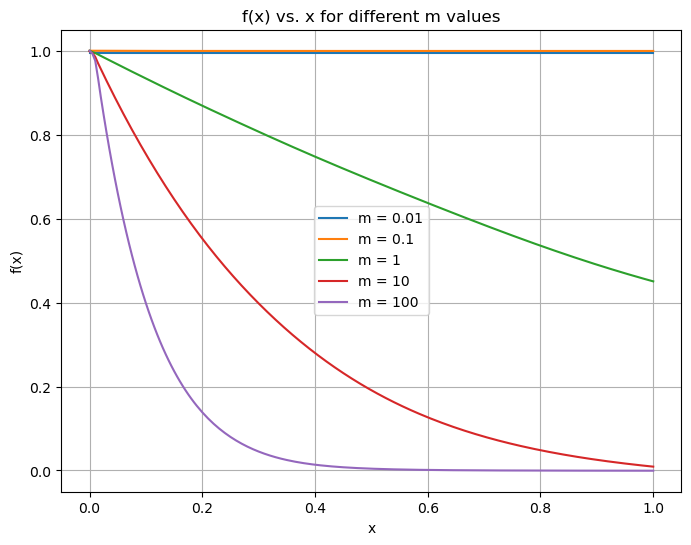

In [31]:
plt.figure(figsize=(8, 6))

for m in m_values:
    plt.plot(x_train1.cpu().detach().numpy(), results[m], label=f"m = {m}")

plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("f(x) vs. x for different m values")
plt.legend()
plt.grid(True)
plt.show()